In [144]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [159]:
%%cython


import numpy as np
cimport numpy as np
cimport cython
from cython import boundscheck, wraparound
import math
from libc.math cimport sin as csin
from libc.math cimport cos as ccos
from libc.math cimport asin as casin
from libc.math cimport exp as cexp
import random
import glob
import tqdm
import math
from scipy import integrate
import cmath
import atom as at
import sys




DTYPE_int = np.int64
DTYPE_double = np.float64
ctypedef np.int64_t DTYPE_int_t
ctypedef np.float64_t DTYPE_double_t

PI = np.pi
SIN = np.sqrt(3)/2.0
CONST1 = 2/np.sqrt(6)
CONST2 = 1/np.sqrt(2)
EPS=1E-6
B_par = 1.519
B_perp = 54.00


cdef dict wvl_dic = {}
wvl_dic={} #X線の波長
wvl_dic['Cu_Ka'] = 1.54059 # in Ang.
wvl_dic['Mo_Ka'] = 0.71069 # in Ang.
wvl = wvl_dic['Cu_Ka']

cdef str shape = 'triangle'

# cdef list od_B=[]
# cdef list obj = od_B
# cdef list site_symmetry = [-1]
# cdef list myModel = [position,shape,obj,site_symmetry]

##逆格子空間での射影
from math import pi, sqrt
from math import sqrt
cdef prjctn_recipro_par(list[long] r, double a=1.0, double c=1.0):
    """
    parallel component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    float:c, lattice constant
    """
    cdef double x, y, z
    x = (1*r[0]+SIN*r[1]+0.5*r[2]       )/a*CONST2
    y = (       0.5*r[1]+SIN*r[2]+1*r[3])/a*CONST2
    z = r[4]/c
    return [x,y,z]

cdef prjctn_recipro_perp(list[long] r,double a=1.0):
    """
    perpendicular component of 5D reciprocal lattice vector
    input
    list:r, 4D reflection index
    float:a, lattice constant
    """
    cdef double x, y
    x=(1*r[0]-SIN*r[1]+0.5*r[2]     )/a*CONST2
    y=(       0.5*r[1]-SIN*r[2]+r[3])/a*CONST2
    return [x,y]

cdef prjctn_recipro_par_length(list[long] r, double a=1.0, double c=1.0):
    cdef double x, y, z
    [x,y,z]=prjctn_recipro_par(r,a,c)
    return sqrt(x**2+y**2+z**2)

cdef prjctn_recipro_perp_length(list[long] r, double a=1.0):
    cdef double x, y
    [x,y]=prjctn_recipro_perp(r,a)
    return sqrt(x**2 + y**2)

##実空間の射影
from math import pi, sqrt
from math import sqrt

cdef prjctn_direct_par(list[long] r, double a=1.0, double c=1.0):
    """
    parallel component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    float:c, lattice constant
    """
    cdef double x, y, z
    x = ( SIN*r[0]+r[1]     -0.5*r[3])*a*CONST1
    y = (-0.5*r[0]     +r[2]+SIN*r[3])*a*CONST1
    z = r[4]*c
    return [x,y,z]

cdef prjctn_direct_perp(list[long] r, double a=1.0):
    """
    perpendicular component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    """
    cdef double x, y
    x = (-SIN*r[0]+r[1]-0.5*r[3])*a*CONST1
    y = (-0.5*r[0]+r[2]-SIN*r[3])*a*CONST1
    return [x,y]

cdef prjctn_direct_par_length(list[long] r,double a=1.0, double c=1.0):
    cdef double x, y, z
    [x,y,z]=prjctn_direct_par(r,a,c)
    return sqrt(x**2+y**2+z**2)

cdef prjctn_direct_perp_length(list[long] r, double a=1.0):
    cdef double x, y
    [x,y]=prjctn_direct_perp(r,a)
    return sqrt(x**2+y**2)

##ピークリストファイル読み込み
def read_file(file):
    """
    read a file
    input:
    :param file: file name of the imput.
    """
    try:
        f=open(file,'r')
    except IOError as e:
        print(e)
        sys.exit(0)
    line=[]
    while 1:
        a=f.readline()
        if not a:
            break
        line.append(a[:-1])
    return line

reflist = read_file("./reflection_list.ref")

peaks_dict = {}
for i in range(1,len(reflist)):
    b = reflist[i].split()
    hklmno = np.array([long(b[0]),long(b[1]),long(b[2]),long(b[3]),long(b[4])])
    multiplicity = long(b[5])
    g_par = float(b[6])
    g_perp = float(b[7])
    peaks_dict[i] = [hklmno,multiplicity,g_par,g_perp]
    # print(hklmno)
    # print(multiplicity)
    #print(g_par)
    #print(g_perp)
# print(peaks_dict)
    # print(multiplicity)

##回折角
cdef reflection_angle(double wvl, list[long] hklmno, double a, double c):
    """
    return theta-angle in rad.
    """
    cdef double qpar, theta
    qpar = prjctn_recipro_par_length(hklmno,a,c)
    theta = casin(qpar*wvl/2)
    return theta

##フーリエ変換
import math
# from scipy import integrate
import cmath

cdef double TWOPI = 2.0*PI

cdef calc_FT(list[long] hkl, list[double] xyz):
    """
    格子のフーリエ変換の計算
    see
    Yamamoto, qcdiff, qcdiff1.f90, L.1789, subroutine stfcd(h,f,fn,dfdxx,q,ny,dfdbia)

    input:

    :param array hkl:
    :param array xyz:
    """
    cdef double complex con1
    cdef double complex val
    val = 0.0+0.0*1j
    #print('  hkl = ',hkl)
    #print('  xyz = ',xyz)
    if xyz.ndim == 1:
        con1 = np.dot(hkl,xyz)
        #print('  con1 = ',con1)
        val = cmath.exp(TWOPI*con1*1j)
    elif xyz.ndim == 2:
        for i in range(len(xyz)):
            con1 = np.dot(hkl,xyz[i])
            val += cmath.exp(TWOPI*con1*1j)
    else:
        print('check your model')
    return val

##ODのフーリエ変換
cdef fourier2d_qcdiff_0(list[double] e1i, list[double] e2i, list[long] hkl, double ad, double scl, double eps):
    """
    Fourier integral of a triangle defined by e1 and e2.
    Reference:
    Yamamoto, qcdiff, occupdom.f90, L.956, complex function fq0d(hr,e1,e2,v,rmax,dfqdr)

    input:

    :param vertex coordinates of the triangle, e1 and e2
    :param nd.array: hkl
    :param float: ad
    :param float: scl (= rmax, in qcdiff)
    :param float: eps
    """
    cdef list[double] qi, vol, val
    cdef double q1, q2, q3
    cdef double complex cexp01, cexp02, cexp1, cexp2, dcq1dq
    #projection onto the internal space of reflection indices
    qi = prjctn_recipro_perp(hkl,ad)
    qi = np.array(qi)

    #volume of the triangle
    vol = abs(np.cross(e1i,e2i))/2.0*scl**2

    q1 = TWOPI*np.dot(qi,e1i)*scl
    q2 = TWOPI*np.dot(qi,e2i)*scl
    q3 = q1-q2 # ここ重要：q2-q1ではない！

    cexp01 = cmath.exp(1j*q1)-1
    cexp02 = cmath.exp(1j*q2)-1
    cexp1 = cmath.exp(1j*q1)-1-1j*q1
    cexp2 = cmath.exp(1j*q2)-1-1j*q2
    dcq1dq = 1j*cmath.exp(1j*q1)-1j

    if abs(q1)<eps and abs(q2)<eps:
        val = vol/2.0
    elif abs(q1)<eps:
        val = -vol*cexp2/q2**2
    elif abs(q2)<eps:
        val = -vol*cexp1/q1**2
    elif abs(q3)<eps:
        val = vol*(cexp1/q1**2-dcq1dq/q1)
    else:
        val = vol*(q1*cexp02-q2*cexp01)/(q1*q2*q3)

    return val

cdef fpoly(list[double] od,list[long] hkl, str flag,double ad, double scl, double eps):
    """This function returns Fourier integral of an indipendent occupation domain (multi-triangles)

    Parameters
    ----------
    od: list
        occupation domain(set of triangle)
    hkl: list
        reflection index
    site: ndarray
        centre position of the od
    ad: float
        dodecagonal lattica constalt
    scl: float
        scale
    flag: int
        (0) od
        (1) inversion of od is used for calculation
    eps: float

    Returns
    -------
    """
    cdef list[double] e1, e2
    cdef double complex out
    out=0.0+0.0*1j
    for triangle in od:
        e1=triangle[1]-triangle[0]
        e2=triangle[2]-triangle[0]
        e1 = prjctn_direct_perp(e1,ad)
        e2 = prjctn_direct_perp(e2,ad)
        out+=fourier2d_qcdiff_0(e1,e2,hkl,ad,scl,eps)
    if flag==0:
        return out
    else:
        # odに反転操作を行ったもののフーリエ変換は、odのフーリエ変換の共役になる。
        return out.conjugate()

cdef calc_od_FT(str shape, list obj, list[long] hkl, position,list site_symmetry,double flag=0.0, double ad=1.0, double scl=1.0, double eps=1E-3):
    """This returns Fourier integral of an occupation domain.

    Parameters
    ----------
    shape: str
        shape of the occupation domain.
    obj: list
        occupation domain(set of triangle)
    hkl: list
        reflection index
    position: ndarray
        centre position of the od
    site_symmetry: list
        index of symmetry operation of the site symmetry
    flag: int
        (0) the model is centre symmetric
        (1) the model is not centre symmetric
    ad: float
        dodecagonal lattica constant
    scl: float
        scale
    eps: float

    Returns
    -------
    """
    cdef list[double] od
    if shape == 'triangle':
        if site_symmetry==[-1]: # symmetric ODs
            od=obj
        # else: # asymmetric unit of ODs
        #     od=generator_obj_symmetric_obj_specific_symop(obj,position,site_symmetry)
            #n1,n2,n3,n4,n5=od.shape
            #od=od.reshape(n1*n2,n3,n4,n5)
        return fpoly(od,hkl,flag,ad,scl,eps)

    else:
        print('OD shape error')
        return

##ODの定義
cdef double[:, :, :] od_B

od_B = np.array([
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0], [-1.0, 0.0, 0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [-1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -1.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0], [0.0, -1.0, 0.0, -1.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, -1.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, -1.0, 0.0, 0.0]],
    [[.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 1.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 1.0, 0.0], [-1.0, 0.0, -1.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0, 0.0, 0.0], [-1.0, 0.0, -1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0]]
], dtype=np.float64)

cdef double[:, :, :] obj = od_B

#指数発生
##原子散乱因子
import atom as at
cdef calc_asf(str element, double theta): # Atomic scattering factor
    cdef list[str] p
    cdef list[double]a, b, c
    cdef double sum, wvl
    cdef dict wvl_dic = {}
    wvl_dic={} #X線の波長
    wvl_dic['Cu_Ka'] = 1.54059 # in Ang.
    wvl_dic['Mo_Ka'] = 0.71069 # in Ang.
    wvl = wvl_dic['Cu_Ka']
    p = at.aff_parameters[element]
    a = [p[0], p[2], p[4], p[6], p[8]]
    b = [p[1], p[3], p[5], p[7], p[9]]
    c = p[10]
    sum_ = 0.0
    for i in range(5):
        sum_ = sum_+ a[i]*math.exp(-1.0*b[i]*csin(theta/180.0*np.pi)**2.0/wvl**2.0)
    return sum_+c

##ローレンツ因子
# cdef calc_LP(double theta): #Lorentz-polarization factor
#     cdef double p1, p2, p3
#     p1=ccos(2.0*theta/180.0*np.pi)
#     p2=csin(theta/180.0*np.pi)
#     p3=ccos(theta/180.0*np.pi)
#     return (1.0+p1**2.0)/p2**2.0/p3

# 必要なライブラリのインポート
from libc.math cimport cos, sin, pi  # 'cos', 'sin', 'pi' を libc.math からインポート

cdef double calc_LP(double theta):  # Lorentz-polarization factor
    cdef double p1, p2, p3

    # 計算
    p1 = cos(2.0 * theta / 180.0 * pi)  # cos関数を使用
    p2 = sin(theta / 180.0 * pi)  # sin関数を使用
    p3 = cos(theta / 180.0 * pi)  # cos関数を使用

    # 結果を返す
    return (1.0 + p1**2.0) / (p2**2.0 * p3)


cdef temfact(double B_par, double B_perp, double g_par, double g_perp):
    # for g in peaks_dict.values():
    return math.exp(-(B_par*g_par**2+B_perp*g_perp**2)/4)


##ローレンツ関数畳み込み
cpdef Lorenz(list[double] p, double x): #Lorenzian
    return ((p[0]*p[1]**2/((x-p[2])**2+p[1]**2)))


##構造因子の計算
cpdef structure_factor(dict[double] peaks_dict, double a, double c, double wvl, list myModel, str elm_A, str elm_B, str flag, double p):
    cdef list theta_list, obj, site_symmetry, position
    cdef dict intensity_dict
    # cdef list hklmno

    # cdef np.ndarray[double, ndim=1] theta_list
    # cdef np.ndarray[double, ndim=12] obj
    # cdef np.ndarray[int, ndim=1] site_symmetry
    cdef np.ndarray[long, ndim=1] hklmno

    cdef int multiplicity
    cdef double g_par, g_perp, theta, xaxis, asf1, asf2, q_per_len, TF, LP, intensity
    cdef double complex pos_FT, od_FT, sfacs1, sfacs2, sfacs
    cdef str shape
    theta_list = []
    intensity_dict = {}
    for nref in peaks_dict:
        hklmno, multiplicity,g_par,g_perp = peaks_dict[nref]
        theta=reflection_angle(wvl,hklmno,a,c) # in rad.
        q_par_len=2*csin(theta)/wvl # in Ang*{-1}
        if theta>0. and theta<PI/2.0:
            position,shape,obj,site_symmetry = myModel
            xaxis = 2*theta/PI*180 # tth in degree
            xaxis = round(xaxis,3)
            pos_FT = calc_FT(hklmno,position)
            od_FT = calc_od_FT(shape,obj,hklmno,position,site_symmetry,flag=0.0,ad=1.0,scl=1.0,eps=1E-3)

            asf1 = calc_asf(elm_A, xaxis)
            asf2 = calc_asf(elm_B, xaxis)

            q_per_len=prjctn_recipro_perp_length(hklmno)
            TF = temfact(B_par,B_perp,q_par_len,q_per_len)

            LP = calc_LP(xaxis)

            sfacs1 = pos_FT*od_FT*p*asf1*TF
            sfacs2 = pos_FT*od_FT*(1-p)*asf2*TF
            sfacs = sfacs1+sfacs2

            intensity = LP*multiplicity*(sfacs.real**2 + sfacs.imag**2)

            try:
                intensity_dict[xaxis] += intensity.real
            except:
                intensity_dict[xaxis] = intensity.real
        else:
            pass
    return intensity_dict






# cdef int hmax=5
# cdef int lmax=4
cdef double a=7.886
cdef double c=10.403

cdef double qemax = 2/wvl # in Ang.^{-1}
cdef double qimax = 0.5

cdef str flag = 'unique'

import numpy as np
cimport numpy as np
cdef double[:] position
position = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
cdef list site_symmetry = [-1]
myModel = [position,shape,obj,site_symmetry]


Content of stderr:
In file included from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_2eab70a9bc6883a4504b05c65a28e2741e07d532.c:1326:
/usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/root/.cache/ipython/cython/_cython_magic_2eab70a9bc6883a4504b05c65a28e2741e07d532.c:21485:18: warning: ‘__pyx_f_54_cython_magic_2eab70a9bc6883a4504b05c65a28e2741e07d532_prjctn_direct_perp_length’ defined but not used [-Wunused-function]
21485 |

In [ ]:
print(type(myModel))

<class 'list'>


In [160]:
tth_min=0
tth_max=60
tth_step=0.01
data_num=5

In [161]:
xaxis_min=0
xaxis_max=60
xaxis_step=0.01

In [162]:
%%cython

import numpy as np
cimport numpy as np
cimport cython
from cython import boundscheck, wraparound
import math
from libc.math cimport sin as csin
from libc.math cimport cos as ccos
from libc.math cimport asin as casin
from libc.math cimport exp as cexp
import random
import glob
import tqdm

cdef double PI = math.pi
cdef double TWOPI = 2.0*PI
cdef double TAU = (1.0+math.sqrt(5))/2.0
cdef double CONST1 = 1.0/2.0/math.sqrt(TAU+2)
cdef double EPS = 1E-06

DTYPE_int = np.int64
DTYPE_double = np.float64
ctypedef np.int64_t DTYPE_int_t
ctypedef np.float64_t DTYPE_double_t



cdef np.ndarray[DTYPE_double_t, ndim = 1]  LorentzianProfile(list p, np.ndarray[DTYPE_double_t, ndim = 1] x_array):
    # Peak profile: Lorenzian
    return ((p[0]*p[1]**2/((x_array - p[2])**2 + p[1]**2)))


###############
## Multi-iQC# #
###############

cpdef np.ndarray calc_multiQC(list QC_vectors_list, double xaxis_min, double xaxis_max, double xaxis_step):
    cdef int strong_num_min, strong_num_max, weak_num_min, weak_num_max, len_xaxis, data_num, index, __, strong_num, weak_num
    cdef double hwhm, tth, Intensity
    cdef list multiQC_vectors_list, strong_xaxis_list, weak_xaxis_list, Lorenzian_list, noise_list
    cdef np.ndarray[DTYPE_double_t, ndim=1] xaxis_array, QC_vector, fake_vector, multiQC_vector, noise_array

    strong_num_min, strong_num_max, weak_num_min, weak_num_max = 0, 30, 0, 100
    multiQC_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
    len_xaxis = len(xaxis_array)
    data_num = len(QC_vectors_list)

    for index in range(data_num):
        QC_vector, hwhm = QC_vectors_list[index]
        strong_xaxis_list = []
        weak_xaxis_list = []
        strong_num = random.randint(strong_num_min, strong_num_max)
        weak_num = random.randint(weak_num_min, weak_num_max)
        if strong_num == weak_num == 0:
            multiQC_vectors_list.append(np.array([0.0]*len(xaxis_array)))
            continue
        for __ in range(strong_num):
            strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
        for __ in range(weak_num):
            weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))

        fake_vector = np.array([0.0]*len(xaxis_array))
        for xaxis in strong_xaxis_list:
            Intensity = random.uniform(0.1, 1.0)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        for xaxis in weak_xaxis_list:
            Intensity = random.uniform(0, 0.1)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        fake_vector -= np.min(fake_vector)
        fake_vector /= np.max(fake_vector)

        if random.random() > 0.5:
            multiQC_vector = QC_vector*random.uniform(0.2,1.0) + fake_vector
        else:
            multiQC_vector = QC_vector + fake_vector*random.uniform(0.0,1.0)

        noise_list = []
        for __ in range(len_xaxis):
            noise_list.append(random.uniform(0.0, 0.01))
        noise_array = np.array(noise_list, dtype = DTYPE_double)
        multiQC_vector += noise_array
        multiQC_vector -= np.min(multiQC_vector)
        multiQC_vector /= np.max(multiQC_vector)
        multiQC_vectors_list.append(multiQC_vector)

    return np.array(multiQC_vectors_list, dtype = DTYPE_double)

In [163]:
data_list = []
multiQC_data_list=[]

# list1 = []
# list1.append(at.aff_parameters.keys())
list1 = list(at.aff_parameters.keys())

rng = np.random.default_rng()
for __ in tqdm.tqdm(range(data_num), desc='training data'):
    # a = random.randrange(7.0, 9.0, 0.025)
    # c = random.randrange(10.0, 12.0, 0.025)
    ##a
    start=7.0
    stop=9.0
    step=0.025
    a = random.randrange(int(start / step), int(stop / step) + 1) * step

    ##b
    start=10.0
    stop=12.0
    step=0.025
    b = random.randrange(int(start / step), int(stop / step) + 1) * step
    # a = rng.uniform(7.0, 9.0)
    # c = rng.uniform(10.0, 12.0)
    # a = 7.0
    # c = 10.0
    # element = np.random.choice(list(at.aff_parameters.keys()))

    # elm_A = np.random.choice(list(at.aff_parameters.keys()))
    # print(list(at.aff_parameters.keys()))
    # # popped_item = list(at.aff_parameters.keys()).pop(elm_A)
    # elm_B = np.random.choice(list(at.aff_parameters.keys()))

    elm_A = np.random.choice(list1)
    # popped_item = list1.pop(elm_A)
    elm_A = str(elm_A)
    list1.remove(str(elm_A))
    elm_B = np.random.choice(list1)
    elm_B = str(elm_B)
    list1.append(elm_A)
    # print(elm_A)
    # print(elm_B)
    hwhm = rng.uniform(0.01, 0.1)
    p = rng.uniform(0, 1)
    # element = 'Ta'
    # hwhm = 0.01
    inten_dict = structure_factor(peaks_dict,a,c,wvl,myModel,elm_A,elm_B,flag,p)
    len_pattern = int((tth_max-tth_min)/tth_step)
    vector=np.array([0.0]*len_pattern)
    tths = np.arange(tth_min, tth_max, tth_step)
    #print(tths)
    for tth in inten_dict.keys():
        #print(tth)
        # inten_dict[tth][0]
        vector += Lorenz([inten_dict[tth], hwhm*random.uniform(0.95,1.0), tth], tths)
    vector = vector/np.max(vector)
    # data_list.append(vector)
    data_list.append([vector, hwhm])
    multiQC_data_list=calc_multiQC(data_list, xaxis_min, xaxis_max, xaxis_step)
    print(multiQC_data_list)

#     multiQC_data_list=[]
# multiQC_data_list=calc_multiQC(data_list, xaxis_min, xaxis_max, xaxis_step)
# np.list(data_list)
# data_list = list(data_list)
# data_array = np.array(data_list)
data_array = np.array(multiQC_data_list, dtype=object)
np.save('sample_dodeca.npy', data_array)

training data:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: Expected list, got numpy.ndarray

In [ ]:
rng = np.random.default_rng()
p = rng.uniform(0, 1)

In [ ]:
print(type(p))
print(p)

<class 'float'>
0.3873929490441632


#### プロット

<function matplotlib.pyplot.show(close=None, block=None)>

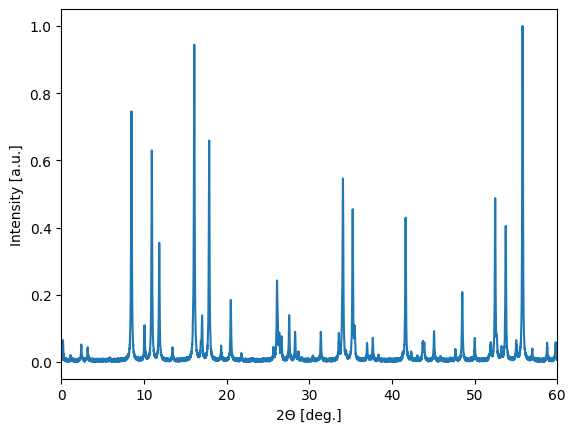

In [ ]:
#plot scatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(1):
    plt.plot(tths,multiQC_data_list[i])
plt.xlim(tth_min,tth_max)
plt.xlabel('2Θ [deg.]')
plt.ylabel('Intensity [a.u.]')
#plt.legend()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.show